# Bike-Sharing Dataset

The Bike-Sharing Dataset contains the bike rentals for almost every hour over the period 2011 and 2012. 
The dataset contains 14 features and we select the 11 features that are relevant to the prediction task. 
The features contain information about the day, like the month, the hour, the day of the week, the day-type,
and the weather conditions. 

Lets take a closer look!

In [14]:
import effector
import pandas as pd
import tensorflow as tf
from tensorflow import keras

## Preprocess the data

In [15]:
# load dataset
df = pd.read_csv("./../data/Bike-Sharing-Dataset/hour.csv")

# drop columns
df = df.drop(["instant", "dteday", "casual", "registered", "atemp"], axis=1)

In [16]:
for col_name in df.columns:
    print("Feature: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(col_name, len(df[col_name].unique()), df[col_name].mean(), df[col_name].std(), df[col_name].min(), df[col_name].max()))

Feature: season         , unique:    4, Mean:   2.50, Std:   1.11, Min:   1.00, Max:   4.00
Feature: yr             , unique:    2, Mean:   0.50, Std:   0.50, Min:   0.00, Max:   1.00
Feature: mnth           , unique:   12, Mean:   6.54, Std:   3.44, Min:   1.00, Max:  12.00
Feature: hr             , unique:   24, Mean:  11.55, Std:   6.91, Min:   0.00, Max:  23.00
Feature: holiday        , unique:    2, Mean:   0.03, Std:   0.17, Min:   0.00, Max:   1.00
Feature: weekday        , unique:    7, Mean:   3.00, Std:   2.01, Min:   0.00, Max:   6.00
Feature: workingday     , unique:    2, Mean:   0.68, Std:   0.47, Min:   0.00, Max:   1.00
Feature: weathersit     , unique:    4, Mean:   1.43, Std:   0.64, Min:   1.00, Max:   4.00
Feature: temp           , unique:   50, Mean:   0.50, Std:   0.19, Min:   0.02, Max:   1.00
Feature: hum            , unique:   89, Mean:   0.63, Std:   0.19, Min:   0.00, Max:   1.00
Feature: windspeed      , unique:   30, Mean:   0.19, Std:   0.12, Min:   0.00, 

Feature Table:

| Feature      | Description                            | Value Range                                         |
|--------------|----------------------------------------|-----------------------------------------------------|
| season       | season                                 | 1: winter, 2: spring, 3: summer, 4: fall            |
| yr           | year                                   | 0: 2011, 1: 2012                                    |
| mnth         | month                                  | 1 to 12                                             |
| hr           | hour                                   | 0 to 23                                             |
| holiday      | whether the day is a holiday or not    | 0: no, 1: yes                                       |
| weekday      | day of the week                        | 0: Sunday, 1: Monday, …, 6: Saturday                |
| workingday   | whether the day is a working day or not | 0: no, 1: yes                                      |
| weathersit   | weather situation                      | 1: clear, 2: mist, 3: light rain, 4: heavy rain     |
| temp         | temperature                            | normalized, [0.02, 1.00]                            |
| hum          | humidity                               | normalized, [0.00, 1.00]                            |
| windspeed    | wind speed                             | normalized, [0.00, 1.00]                            |


Target:

| Target       | Description                            | Value Range                                         |
|--------------|----------------------------------------|-----------------------------------------------------|
| cnt          | bike rentals per hour                  | [1, 977]                                            |


In [17]:
def preprocess(df):
    # shuffle
    df.sample(frac=1).reset_index(drop=True)

    # Standarize X
    X_df = df.drop(["cnt"], axis=1)
    x_mean = X_df.mean()
    x_std = X_df.std()
    X_df = (X_df - X_df.mean()) / X_df.std()

    # Standarize Y
    Y_df = df["cnt"]
    y_mean = Y_df.mean()
    y_std = Y_df.std()
    Y_df = (Y_df - Y_df.mean()) / Y_df.std()
    return X_df, Y_df, x_mean, x_std, y_mean, y_std

# shuffle and standarize all features
X_df, Y_df, x_mean, x_std, y_mean, y_std = preprocess(df)

In [18]:
def split(X_df, Y_df):
    # data split
    X_train = X_df[:int(0.8 * len(X_df))]
    Y_train = Y_df[:int(0.8 * len(Y_df))]
    X_test = X_df[int(0.8 * len(X_df)):]
    Y_test = Y_df[int(0.8 * len(Y_df)):]
    return X_train, Y_train, X_test, Y_test

# train/test split
X_train, Y_train, X_test, Y_test = split(X_df, Y_df)

## Fit a Neural Network

We train a deep fully-connected Neural Network with 3 hidden layers for \(20\) epochs. 
The model achieves a mean absolute error on the test of about \(38\) counts.

In [19]:
# Train - Evaluate - Explain a neural network
model = keras.Sequential([
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae", keras.metrics.RootMeanSquaredError()])
model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1)
model.evaluate(X_train, Y_train, verbose=1)
model.evaluate(X_test, Y_test, verbose=1)


Epoch 1/20
28/28 [==============================] - 1s 11ms/step - loss: 0.4514 - mae: 0.4901 - root_mean_squared_error: 0.6719
Epoch 2/20
28/28 [==============================] - 0s 14ms/step - loss: 0.3170 - mae: 0.4062 - root_mean_squared_error: 0.5630
Epoch 3/20
28/28 [==============================] - 0s 12ms/step - loss: 0.2487 - mae: 0.3528 - root_mean_squared_error: 0.4987
Epoch 4/20
28/28 [==============================] - 0s 12ms/step - loss: 0.1840 - mae: 0.2992 - root_mean_squared_error: 0.4289
Epoch 5/20
28/28 [==============================] - 0s 14ms/step - loss: 0.1331 - mae: 0.2533 - root_mean_squared_error: 0.3648
Epoch 6/20
28/28 [==============================] - 0s 12ms/step - loss: 0.1045 - mae: 0.2255 - root_mean_squared_error: 0.3232
Epoch 7/20
28/28 [==============================] - 0s 14ms/step - loss: 0.0822 - mae: 0.1987 - root_mean_squared_error: 0.2867
Epoch 8/20
28/28 [==============================] - 0s 14ms/step - loss: 0.0615 - mae: 0.1708 - root_mea

[0.16780102252960205, 0.2781440317630768, 0.4096352458000183]

## Explain

In [20]:
def model_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

def model_forward(x):
    return model(x).numpy().squeeze()


In [21]:
scale_x = {"mean": x_mean[3], "std": x_std[3]}
scale_y = {"mean": y_mean, "std": y_std}
scale_x_list =[{"mean": x_mean[i], "std": x_std[i]} for i in range(len(x_mean))]
feature_names = X_df.columns.to_list()
target_name = "bike-rentals"

## Global Effect

### PDP 

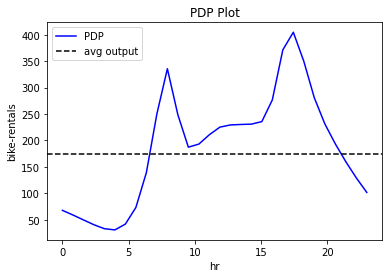

In [22]:
pdp = effector.PDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=5000)
fig, ax = pdp.plot(feature=3, centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

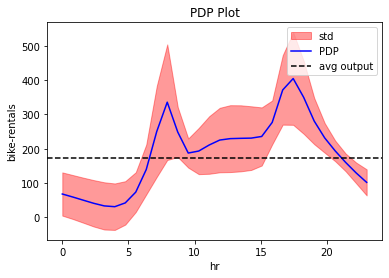

In [23]:
fig, ax = pdp.plot(feature=3, confidence_interval="std", centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

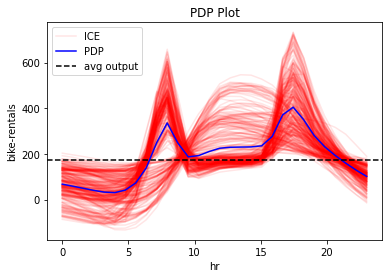

In [24]:
fig, ax = pdp.plot(feature=3, confidence_interval="ice", centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True, nof_ice=300)

In [25]:
### RHALE

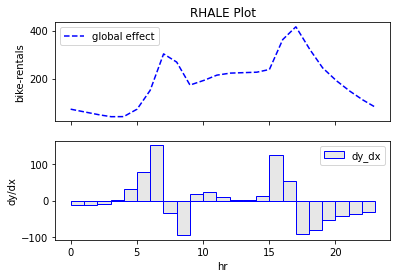

In [26]:
rhale = effector.RHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name)
binning_method = effector.binning_methods.Greedy(init_nof_bins=1000, min_points_per_bin=100, discount=0, cat_limit=10)
rhale.fit(features=3, binning_method=binning_method)
rhale.plot(feature=3, centering=True, scale_x=scale_x, scale_y=scale_y)

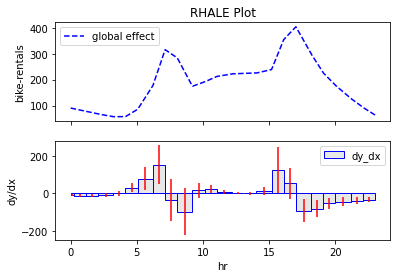

In [27]:
rhale = effector.RHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name)
binning_method = effector.binning_methods.Greedy(init_nof_bins=100, min_points_per_bin=100, discount=0, cat_limit=10)
rhale.fit(features=3, binning_method=binning_method)
rhale.plot(feature=3, confidence_interval="std", centering=True, scale_x=scale_x, scale_y=scale_y)

# Regional Effects

### RegionalRHALE

In [28]:
# Regional RHALE
regional_rhale = effector.RegionalRHALE(
    data=X_train.to_numpy(),
    model=model_forward,
    model_jac=model_jac,
    cat_limit=10,
    feature_names=feature_names,
)

regional_rhale.fit(
    features=3,
    heter_small_enough=0.1,
    heter_pcg_drop_thres=0.1,
    binning_method="greedy",
    max_split_levels=2,
    nof_candidate_splits_for_numerical=5,
    min_points_per_subregion=10,
    candidate_conditioning_features="all",
    split_categorical_features=True,
)

100%|██████████| 1/1 [00:16<00:00, 16.67s/it]


In [29]:
regional_rhale.describe_subregions(features=3, only_important=True, scale_x=scale_x_list)

Important splits for feature hr
- On feature workingday (cat)
  - Range: [0.00, 1.00]
  - Candidate split positions: 0.00, 1.00
  - Position of split: 0.00
  - Heterogeneity before split: 5.27
  - Heterogeneity after split: 3.41
  - Heterogeneity drop: 1.86 (54.67 %)
  - Number of instances before split: 13903
  - Number of instances after split: [4387, 9516]
- On feature temp (cont)
  - Range: [0.02, 1.00]
  - Candidate split positions: 0.12, 0.31, 0.51, 0.71, 0.90
  - Position of split: 0.51
  - Heterogeneity before split: 3.41
  - Heterogeneity after split: 2.82
  - Heterogeneity drop: 0.59 (20.78 %)
  - Number of instances before split: [4387, 9516]
  - Number of instances after split: [2390, 1997, 4610, 4906]


/home/givasile/miniconda3/envs/effector/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/givasile/miniconda3/envs/effector/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/givasile/miniconda3/envs/effector/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


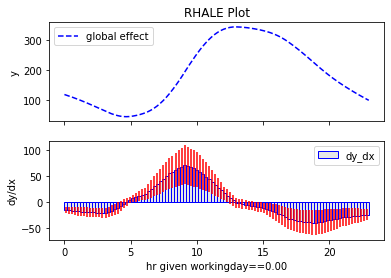

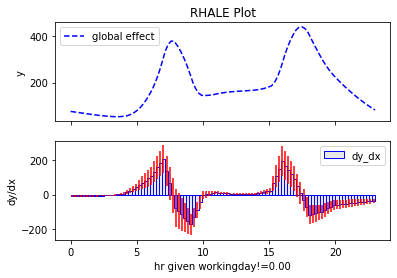

In [30]:

regional_rhale.plot_first_level(feature=3, confidence_interval=True, centering=True, scale_x_per_feature=scale_x_list, scale_y=scale_y)


### RegionalPDP

In [31]:
regional_pdp = effector.RegionalPDP(
    data=X_train.to_numpy(),
    model=model_forward,
    cat_limit=10,
    feature_names=feature_names,
)

regional_pdp.fit(
    features=3,
    heter_small_enough=0.1,
    heter_pcg_drop_thres=0.1,
    max_split_levels=2,
    nof_candidate_splits_for_numerical=5,
    min_points_per_subregion=10,
    candidate_conditioning_features="all",
    split_categorical_features=True,
)

100%|██████████| 1/1 [00:24<00:00, 24.43s/it]


In [32]:

regional_pdp.describe_subregions(features=3, only_important=True, scale_x=scale_x_list)

Important splits for feature hr
- On feature workingday (cat)
  - Range: [0.00, 1.00]
  - Candidate split positions: 0.00, 1.00
  - Position of split: 0.00
  - Heterogeneity before split: 0.50
  - Heterogeneity after split: 0.40
  - Heterogeneity drop: 0.10 (25.13 %)
  - Number of instances before split: 13903
  - Number of instances after split: [4387, 9516]
- On feature temp (cont)
  - Range: [0.02, 1.00]
  - Candidate split positions: 0.12, 0.31, 0.51, 0.71, 0.90
  - Position of split: 0.51
  - Heterogeneity before split: 0.42
  - Heterogeneity after split: 0.31
  - Heterogeneity drop: 0.11 (37.27 %)
  - Number of instances before split: [4387, 9516]
  - Number of instances after split: [2390, 1997, 4610, 4906]


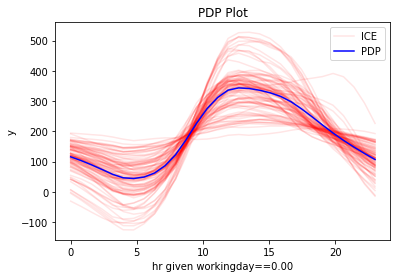

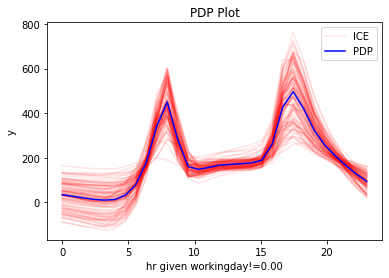

In [33]:

regional_pdp.plot_first_level(feature=3, confidence_interval=True, centering=True, scale_x_per_feature=scale_x_list, scale_y=scale_y)
